In [79]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/Users/omarschall/vanilla-rtrl/')
from utils import get_spectral_radius, norm, rgetattr
import time
from functools import partial

In [4]:
from plants import *
import matplotlib.pyplot as plt

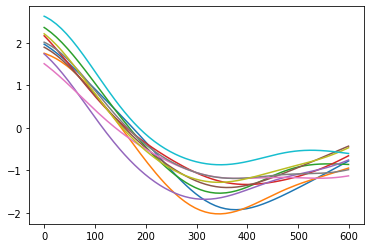

In [5]:
plants = generate_GP_plants(10)
for i in range(10):
    u = np.arange(-3, 3, 0.01)
    plt.plot(plants[i].f(0, u))

In [2]:
class Function:
    """Defines a function and its derivative.

    Attributes:
        f (function): An element-wise differentiable function that acts on a
            1-d numpy array of arbitrary dimension. May include a second
            argument for a label, e.g. for softmax-cross-entropy.
        f_prime (function): The element-wise derivative of f with respect to
            the first argument, must also act on 1-d numpy arrays of arbitrary
            dimension."""

    def __init__(self, f, f_prime):
        """Inits an instance of Function by specifying f and f_prime."""

        self.f = f
        self.f_prime = f_prime
        
### --- Define tanh --- ###

def tanh_(z):

    return np.tanh(z)

def tanh_derivative(z):

    return 1 - np.tanh(z) ** 2

tanh = Function(tanh_, tanh_derivative)

### --- Define ReLu --- ###

right_slope = 1
left_slope = 0
def relu_(h):

    return np.maximum(0, right_slope * h) - np.maximum(0, left_slope * (-h))

def relu_derivative(h):

    return (h > 0) * (right_slope - left_slope) + left_slope

relu = Function(relu_, relu_derivative)

### --- Define Identity --- ###

def identity_(z):

    return z

def identity_derivative(z):

    return np.ones_like(z)

identity = Function(identity_, identity_derivative)

In [153]:
class Cerebellum:
    """The forward model, which produces a control signal in the
    cerebellar nuclei."""
    
    def __init__(self, W_h, W_o, activation):
        """Initialize instance with (fixed) W_h weights for the expansion
        to the GC layer, (trainable) weights W_o for the GC to control
        signal, and elementwise nonlinearity."""
        
        self.W_h = W_h
        self.W_o = W_o
        self.activation = activation
        self.n_in = W_h.shape[1]
        self.n_h = W_h.shape[0]
        
        #right-handed matrix-vector multiplication
        assert self.W_h.shape[0] == self.W_o.shape[1] - 1
        
        #Initial state values
        self.phi = np.zeros(self.W_h.shape[1])
        
    def forward_pass(self, x_0, x_label):
        """Takes in an input x_0, a desired final state x_label, concatenates
        them, and maps them forward, eventually returning a value of u."""
        
        #Concatenate initial state with desired final state
        x = np.concatenate([x_0, x_label])
        
        #GC activation
        self.phi = self.activation.f(np.dot(self.W_h, x))
        self.phi_hat = np.concatenate([self.phi, np.array([1])])
        
        #Control signal output
        self.u = - self.W_o.dot(self.phi_hat)
        
        return self.u.copy()

In [154]:
def Plant(x_0, u, a=-1):
    """Write whatever function you want here, returns
    x_f as a function of x_0 and u."""
    
    return a * u
    
def Plant_derivative(x_0, u, a=-1):
    """Write derivative of plant function (wrt u) if
    desired for comparing gradient descent solution."""
    
    return a

In [155]:
class Climbing_Fibers:
    """Parameterized by theta = (W_1, W_), produces training signals
    for the cerebellum. Currently hard-coded as 1 hidden layer MLP."""
    
    def __init__(self, W_1, W_2, activation, final_output):
        """Initialize with the initial values of the input-hidden (W_1)
        and hidden-output (W_2) weights."""
        
        self.W_1 = W_1
        self.W_2 = W_2
        self.activation = activation
        self.final_output = final_output
        
        assert W_1.shape[0] == W_2.shape[0] - 1
        
        self.n_h = W_1.shape[1]
        
    def __call__(self, x_0, x_label, x_f, u, u_avg, R, R_avg):
        """Return a CF output given the information fed in"""
        
        self.x_cf = np.concatenate([x_0, x_label, x_f, u, u_avg, R, R_avg, np.array([1])])
        self.h = self.W_1.dot(self.x_cf)
        self.a = self.activation.f(self.h)
        self.a_hat = np.concatenate([self.a, np.array([1])])
        self.pre_output = self.W_2.dot(self.a_hat)
        self.CF = self.final_output.f(self.pre_output)
        
        return self.CF.copy()
    
    def get_dPsi_dW(self):
        """Calculate the derivative of the output with respect to the parameters
        theta, as a list of two arrays of shape """
        
        self.dPsi_dpre = self.final_output.f_prime(self.pre_output)
        self.dPsi_dW_2 = self.dPsi_dpre * self.a_hat
        self.dPsi_dW_1 = self.dPsi_dpre * np.multiply.outer(self.W_2[:-1] * self.activation.f_prime(self.h),
                                                            self.x_cf)
        
        return [self.dPsi_dW_1.copy(), self.dPsi_dW_2.copy()]
    
    def update_theta(self, error, plant_derivative, phi, phi_test, dPsi_dW, outer_lr):
        
        dL_dPsi = np.sum(error * plant_derivative * phi * phi_test)
        
        self.dL_dW_1 = dL_dPsi * dPsi_dW[0]
        self.dL_dW_2 = dL_dPsi * dPsi_dW[1]
        
        self.W_1 = np.squeeze(self.W_1 - outer_lr * self.dL_dW_1)
        self.W_2 = np.squeeze(self.W_2 - outer_lr * self.dL_dW_2)
        
    def update_theta_on_gradient(self, CF_error, dPsi_dW, outer_lr):
        
        self.W_1 = np.squeeze(self.W_1 - outer_lr * CF_error * dPsi_dW[0])
        self.W_2 = np.squeeze(self.W_2 - outer_lr * CF_error * dPsi_dW[1])
        

In [238]:
class Inner_Loop:

    def __init__(self, cerebellum, climbing_fibers, plant, plant_derivative,
                 lambda_R=2, alpha_avg=0.05, inner_lr=0.01, outer_lr=0.001,
                 weight_decay=0.95):
        """Initialize an instance of inner loop training with
        the current neural architectures.
        
        kwargs:
            alpha_avg (float): inverse time constant between 0 and
                1 specifying the time scale of averaging u and R.
            lambda_R (float): spatial scale of reward as function
                of error.
            inner_lr (float): learning rate of cerebellum parameters in
                inner loop.
            outer_lr (float): learning rate of climbing fiber parameters
                in the outer loop."""
        
        self.cerebellum = cerebellum
        self.climbing_fibers = climbing_fibers
        self.plant = plant
        self.plant_derivative = plant_derivative
        
        self.alpha_avg = alpha_avg
        self.lambda_R = lambda_R
        self.u_avg = np.array([0])
        self.R_avg = np.array([0])
        self.inner_lr = inner_lr
        self.outer_lr = outer_lr
        self.weight_decay = weight_decay
        
    def run(self, data, mode='train_CF', monitors=[], verbose=True):
        """Take in a data dict of x_0 values and x_label values"""
        
        #Assess size of data
        self.N_loop = len(data['train']['x_0'])
        self.report_interval = max(self.N_loop // 10, 1)
        
        #Initialize monitors
        self.mons = {k: [] for k in monitors}

        #Initialize start time
        self.start_time = time.time()
        
        for i_x in range(self.N_loop):
            
            self.i_x = i_x
            
            self.x_0 = data['train']['x_0'][i_x]
            self.x_label = data['train']['x_label'][i_x]
            
            #Compute cerebellum output, final state, and reward
            self.u = self.cerebellum.forward_pass(self.x_0, self.x_label)
            self.phi = self.cerebellum.phi.copy()
            self.x_f = self.plant(self.x_0, self.u)
            self.train_error = self.x_f - self.x_label
            self.R = np.exp(-1/self.lambda_R * np.abs(self.x_label - self.x_f))
            
            #Update average reward and control
            self.R_avg = (1 - self.alpha_avg) * self.R_avg + self.alpha_avg * self.R
            self.u_avg = (1 - self.alpha_avg) * self.u_avg + self.alpha_avg * self.u
            
            #Calculate CF output
            self.CF = self.climbing_fibers(self.x_0, self.x_label, self.x_f,
                                           self.u, self.u_avg,
                                           self.R, self.R_avg)
            self.CF_label = -self.x_f / self.u * (self.x_f - self.x_label)
            self.RL_solution = (self.u - self.u_avg) * (self.R - self.R_avg)
            
            #Update cerebellum parameters
            #self.cerebellum.W_o = self.weight_decay * self.cerebellum.W_o - self.inner_lr * self.CF * self.cerebellum.phi_hat
            #self.cerebellum.W_o = self.cerebellum.W_o - self.inner_lr * (-self.u - self.x_label) * self.cerebellum.phi_hat
            self.cerebellum.W_o = self.cerebellum.W_o - self.inner_lr * self.CF * self.cerebellum.phi_hat
    
            if mode == 'train_CF':
            
                #Update CF parameters    
                self.x_0_test = data['test']['x_0'][i_x]
                self.x_label_test = data['test']['x_label'][i_x]
                self.u_test = self.cerebellum.forward_pass(self.x_0_test, self.x_label_test)
                self.phi_test = self.cerebellum.phi.copy()
                self.x_f_test = self.plant(self.x_0_test, self.u_test)
                self.error = self.x_f_test - self.x_label_test
                self.g_prime = self.plant_derivative(self.x_0_test, self.u_test)
                dPsi_dW = self.climbing_fibers.get_dPsi_dW()
                self.climbing_fibers.update_theta(self.error, self.g_prime, self.phi, self.phi_test, dPsi_dW,
                                                  self.outer_lr)
                
            #self.CF_label = (-self.u - self.x_label)
            #CF_error = self.CF - self.CF_label
            #self.climbing_fibers.update_theta_on_gradient(CF_error, dPsi_dW, self.outer_lr)
            
            #Update monitors
            self.update_monitors()
            self.get_radii_and_norms()
            
            # Make report if conditions are met
            if (self.i_x % self.report_interval == 0 and
                    self.i_x > 0 and verbose):
                self.report_progress()

        self.monitors_to_arrays()
            
    def update_monitors(self):
        """Loops through the monitor keys and appends current value of any
        object's attribute found."""

        for key in self.mons:
            try:
                self.mons[key].append(rgetattr(self, key))
            except AttributeError:
                pass

    def get_radii_and_norms(self):
        """Calculates the spectral radii and/or norms of any monitor keys
        where this is specified."""

        for feature, func in zip(['radius', 'norm'],
                                 [get_spectral_radius, norm]):
            for key in self.mons:
                if feature in key:
                    attr = key.split('-')[0]
                    self.mons[key].append(func(rgetattr(self, attr)))
                    
    def report_progress(self):
        """"Reports progress at specified interval, including test run
        performance if specified."""

        progress = np.round((self.i_x / self.N_loop) * 100, 2)
        time_elapsed = np.round(time.time() - self.start_time, 1)

        summary = '\rProgress: {}% complete \nTime Elapsed: {}s \n'
        print(summary.format(progress, time_elapsed))
        
    def monitors_to_arrays(self):
        """Recasts monitors (lists by default) as numpy arrays for ease of use
        after running."""

        for key in self.mons:
            try:
                self.mons[key] = np.array(self.mons[key])
            except ValueError:
                pass

In [239]:
class Outer_Loop:
    
    def __init__(self, cerebellum, climbing_fibers, plants, plant_derivatives):
        
        self.cerebellum = cerebellum
        self.n_in = cerebellum.n_in
        self.n_h = cerebellum.n_h
        self.climbing_fibers = climbing_fibers
        self.plants = plants
        self.plant_derivatives = plant_derivatives
        
    def run(self, datasets, inner_lr, outer_lr, mode='train_CF', monitors=[], reset_cerebellum=False):
        
        self.mons = {k: [] for k in monitors}
        
        for i_data, data in enumerate(datasets):
            
            if reset_cerebellum:
                W_h = np.random.normal(0, 1/np.sqrt(2), (self.n_h, self.n_in))
                W_o = np.random.normal(0, 1/np.sqrt(self.n_h), (1, self.n_h + 1))
                self.cerebellum = Cerebellum(W_h, W_o, tanh)
            
            plant = self.plants[i_data]
            plant_derivative = self.plant_derivatives[i_data]
            inner_loop = Inner_Loop(self.cerebellum, self.climbing_fibers,
                                    plant, plant_derivative, inner_lr=inner_lr, outer_lr=outer_lr)
            
            inner_loop.run(data, mode=mode, monitors=monitors, verbose=False)
            
            if (i_data / len(datasets) * 100) % 10 == 0:
                print(i_data)
            
            if i_data == 0:
                self.mons.update(inner_loop.mons)
            else:
                for k in monitors:
                    self.mons[k] = np.concatenate([self.mons[k], inner_loop.mons[k]], axis=0)

In [240]:
def generate_data(N):
    """Function for generating data, may or may not involve the plant"""
    
    data = {'train': {'x_0': np.random.normal(0, 1, (N, 1)),
                      'x_label': np.random.normal(0, 1, (N, 1))},
            'test': {'x_0': np.random.normal(0, 1, (N, 1)),
                     'x_label': np.random.normal(0, 1, (N, 1))}}
    
    return data

In [255]:
#Initialize cerebellum
n_in = 2
n_h = 100
W_h = np.random.normal(0, 1/np.sqrt(2), (n_h, n_in))
W_o = np.random.normal(0, 1/np.sqrt(n_h), (1, n_h + 1))
cerebellum = Cerebellum(W_h, W_o, tanh)

#Initialize climbing fibers
n_cf_in = n_in + 4 + 1 + 1
n_cf_h = 200
W_1 = np.random.normal(0, 1/np.sqrt(n_cf_in), (n_cf_h, n_cf_in))
W_2 = np.random.normal(0, 1/np.sqrt(n_cf_h), (n_cf_h + 1))
climbing_fibers = Climbing_Fibers(W_1, W_2, tanh, identity)

plants = []
plant_derivatives = []
datasets = []
As = []
N_outer = 1000
N_inner = 100
for i in range(N_outer):
    data = generate_data(N_inner)
    datasets.append(data)
    
    a = np.random.normal(0, 1)
    #a = np.random.choice([-1, 1])
    As.append(a)
    plants.append(partial(Plant, a=a))
    plant_derivatives.append(partial(Plant_derivative, a=a))
    
outer_loop = Outer_Loop(cerebellum, climbing_fibers, plants, plant_derivatives)
outer_loop.run(datasets, inner_lr=0.003, outer_lr=0.0001, mode='train_CF',
               monitors=['CF_label', 'CF', 'train_error'], reset_cerebellum=True)
outer_loop.run(datasets, inner_lr=0.003, outer_lr=0.0001, mode='test_CF',
               monitors=['x_f', 'u', 'x_label', 'CF_label', 'CF', 'RL_solution'], reset_cerebellum=True)

0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900


(-3.4282860647552944,
 8.001448496021236,
 -0.7395709719270736,
 0.7039127839298258)

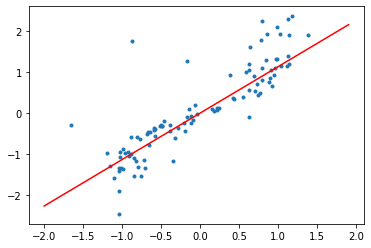

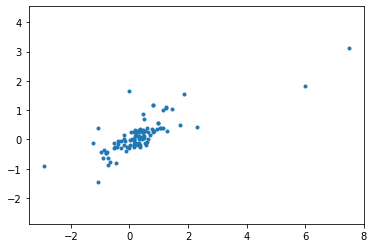

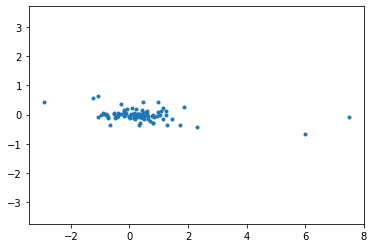

In [271]:
i_loop = 18
plt.figure()
plt.plot(outer_loop.mons['u'][i_loop*N_inner:(i_loop+1)*N_inner],
         outer_loop.mons['x_label'][i_loop*N_inner:(i_loop+1)*N_inner], '.')
u = np.arange(-2, 2, 0.1)
plt.plot(u, As[i_loop] * u, 'r')
plt.figure()
plt.plot(outer_loop.mons['CF'][i_loop*N_inner:(i_loop+1)*N_inner],
         outer_loop.mons['CF_label'][i_loop*N_inner:(i_loop+1)*N_inner], '.')
plt.axis('equal')
plt.figure()
plt.plot(outer_loop.mons['CF'][i_loop*N_inner:(i_loop+1)*N_inner],
         outer_loop.mons['RL_solution'][i_loop*N_inner:(i_loop+1)*N_inner], '.')
plt.axis('equal')

In [196]:
plt.plot(outer_loop.mons['CF'], outer_loop.mons['CF_label'], '.')
plt.axis('equal')

KeyError: 'CF'

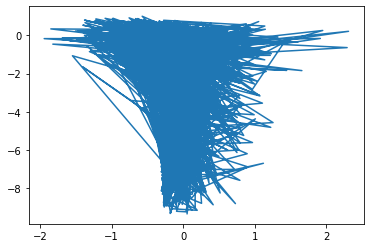

In [18]:
plt.plot(inner_loop.mons['train_error'], inner_loop.mons['CF'])

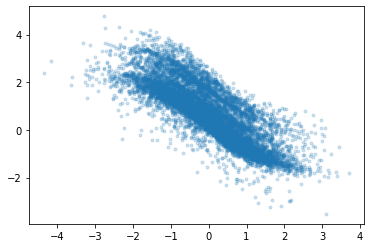

In [72]:
plt.plot(inner_loop.mons['x_label'], inner_loop.mons['u'], '.', alpha=0.2)

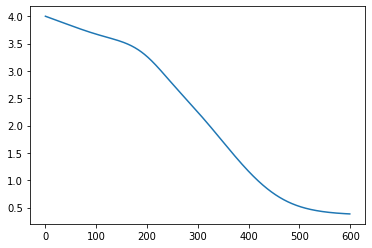

In [73]:
outputs = []
for u in np.arange(-3, 3, 0.01):
    outputs.append(inner_loop.cerebellum.forward_pass(np.array([-2]), np.array([u]))[0])
plt.plot(outputs)

In [ ]:
#Initialize cerebellum
n_in = 2
n_h = 100
W_h = np.random.normal(0, 1/np.sqrt(2), (n_h, n_in))
W_o = np.random.normal(0, 1/np.sqrt(n_h), (1, n_h + 1))
cerebellum = Cerebellum(W_h, W_o, tanh)

#Initialize climbing fibers
n_cf_in = n_in + 4 + 1 + 1
n_cf_h = 200
W_1 = np.random.normal(0, 1/np.sqrt(n_cf_in), (n_cf_h, n_cf_in))
W_2 = np.random.normal(0, 1/np.sqrt(n_cf_h), (n_cf_h + 1))
climbing_fibers = Climbing_Fibers(W_1, W_2, tanh, identity)

inner_loop = Inner_Loop(cerebellum, climbing_fibers, Plant, Plant_derivative, inner_lr=0.001, outer_lr=0.00001)
data = generate_data(10000)
inner_loop.run(data, monitors=['x_f', 'x_label', 'u', 'CF', 'error', 'train_error', 'CF_label'])